# Course Project - Convex Optimization
### Topic - Semi-Stochastic Gradient Descent
### Team Member - Varun Gupta (180851) and Manan Agarwal (180396)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import random
import math
from scipy.special import softmax
from sklearn.datasets import load_iris

## Theoretical Simulations

We will conduct simulation for the formulation of m(j) as mentioned in the paper

In [ ]:
def optimal_parameter(eps,j,k,x):
  d = pow(eps,1/j)
  return (2*x*(k-1)/d + 2*k) * np.log((x/(x-1))/d + (x*k/(x-1) - 1)/(k-1)) #Theoretically obtained formulation

In [ ]:
def basic_plot(eps,j,k):
  plt.rcParams["figure.figsize"] = [7.5,5]
  plt.rcParams["figure.autolayout"] = True

  x = np.linspace(1.05,5,num = 100, endpoint = True) #We vary x in delta/x
  y = optimal_parameter(eps,j,k,x) #creates the array for m(j)

  plt.plot(x,y, color = 'red')
  plt.xlabel("X", fontsize = 12)
  plt.ylabel("m(j)",fontsize = 12)
  plt.title("\u03B5 = {a} j = {b} \u03BA = {c}".format(a=eps, b=j, c = k))
  idx = np.argmin(y) #Calculation of the minimum point 
  plt.annotate('Minimum Point -> {b}'.format(b = round(x[idx],2)),fontsize = 12,
          xy=(x[idx], min(y)), xycoords='data',
          xytext=(0.6, 0.5), textcoords='axes fraction',
          arrowprops=dict(facecolor='black', shrink=0.05),
          horizontalalignment='right', verticalalignment='top')
  return min(y)

In [ ]:
def comparision_plot(eps,j,k,col):
  plt.rcParams["figure.figsize"] = [7.5,5]
  plt.rcParams["figure.autolayout"] = True

  x = np.linspace(1.05,5,num = 100, endpoint = True)
  y = optimal_parameter(eps,j,k,x)

  plt.plot(x,y, col)

28972.708741394123

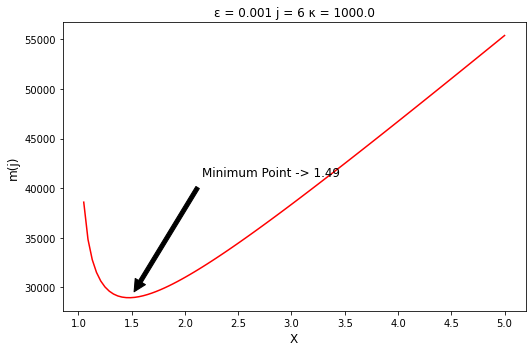

In [ ]:
eps = 1e-3 #Accuracy of the solution
j = 6 #Number of epochs
k = 1e3 #Condition number L/u
basic_plot(eps,j,k)

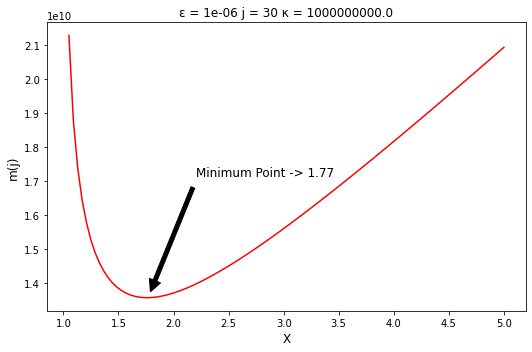

In [ ]:
eps = 1E-6 
j = 30 
k = 1E9 
basic_plot(eps,j,k)

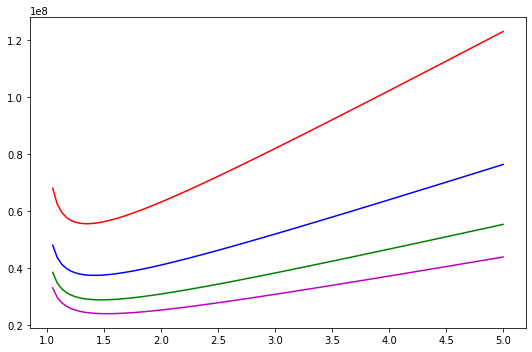

In [ ]:
# Observing the changes with the number of epochs
eps = 1e-3 
k = 1e6
colors = ['-r','-b','-g','-m']
for j in range(4,8):
  comparision_plot(eps,j,k,colors[j-4])

We want to compare the result obtained from the new formulation with the results presented in the paper. We have mentioned the insights from the code below in the paper. 

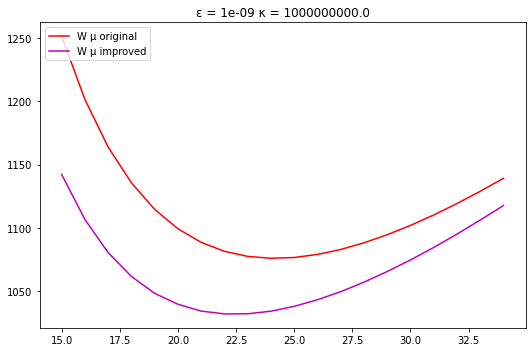

24.0
1076.1452748270058
22.0
1032.2965557428374


In [ ]:
#tunable parameters specific to problem
eps = 1E-9 #Accuracy 
k = 1E9 #condition number

n = 1e9
arr1 = []
arr2 = []
for j in range(15,35):
  x = 2
  val = j*(2*optimal_parameter(eps,j,k,x) + n)/n #evaluation of the total work for m(j) as mentioned in the paper
  arr1.append(val)
  x = np.linspace(1.05,5,num = 100, endpoint = True)
  val = j*(2*min(optimal_parameter(eps,j,k,x)) + n)/n #evaluation of the total work for new m(j) 
  arr2.append(val)
j = np.linspace(15,34,endpoint=True, num =20)
plt.plot(j,arr1,'-r', label = 'W \u03BC original')
plt.plot(j,arr2,'-m', label = 'W \u03BC improved')
plt.legend(loc="upper left")
plt.title("\u03B5 = {a} \u03BA = {c}".format(a=eps, c = k))
plt.show()
print(np.argmin(arr1)+j[0]) #finding epoch number
print(arr1[np.argmin(arr1)]) #finding work equivalent
print(np.argmin(arr2)+j[0])
print(arr2[np.argmin(arr2)])

## Numerical Simulations

## L2-Regularised SoftMax Regression

In [ ]:
def objective(X, Y, W, reg):
  Z = X @ W
  obj = np.trace(Z @ Y.T)
  Z = np.exp(-Z)
  obj += np.sum(np.log(np.sum(Z, axis = 1)))
  obj /= num_sam
  return obj

### Gradient Descent

In [ ]:
def grad(X, Y, W, reg):
  n = np.shape(X)[0]
  Z = X @ W
  S = softmax(-Z, axis = 1)
  grad =  1/n * (X.T @ (Y - S))
  grad += reg * W
  return grad


In [78]:
def GD(X, Y, W, reg, iter, step, loss):
  loss.append(objective(X, Y, W, reg))
  for i in range(iter):
    W = W - step * grad(X, Y, W, reg) #evaluation of full gradient
    loss.append(objective(X, Y, W, reg)) #calculation of the loss function
  return W

In [ ]:
def GD2(X, Y, W, reg, iter, step, loss):
  for i in range(iter):
    W = W - step * grad(X, Y, W, reg) #evaluation of full gradient
  return W

### Stochastic Gradient Descent

In [ ]:
def stoc_grad(X, Y, W, reg):
  n = np.shape(X)[0]
  i = random.sample(range(0, n - 1), 1)[0] # Uniform Random sampling for SGD
  X = X[i, :].reshape((1, num_fe))
  Y = Y[i, :].reshape((1, num_cl))
  return grad(X, Y, W, reg)

In [95]:
def SGD(X, Y, W, reg, iter, step, loss):
  loss.append(objective(X, Y, W, reg))
  for i in range(iter):
    W = W - step * stoc_grad(X, Y, W, reg)
    if((i+1) % num_sam == 0):
      loss.append(objective(X, Y, W, reg))
  return W

### Stochastic Average Gradient

In [ ]:
def stoc_grad2(X, Y, W, reg, i):
  X = X[i, :].reshape((1, num_fe))
  Y = Y[i, :].reshape((1, num_cl))
  return grad(X, Y, W, reg)

In [ ]:
def SAG(X, Y, W, reg, iter, step, loss):
  d = np.zeros((num_fe, num_cl))
  y = np.zeros((num_sam, num_fe, num_cl)) #3d array to store gradients for all points
  loss.append(objective(X, Y, W, reg))
  for i in range(iter):
    j = random.sample(range(0, num_sam - 1), 1)[0]
    var = stoc_grad2(X, Y, W, reg, j)
    d = d - y[j] + var
    y[j] = var #updating gradient wrt the sampled index
    W = W - (step / num_sam) * d #average gradient
    if((i+1) % num_sam == 0):
      loss.append(objective(X, Y, W, reg))
  return W

### Stochastic Variance Reduced Gradient

In [ ]:
def SVRG(X, Y, W, reg, iter, step, loss, m):
  loss.append(objective(X, Y, W, reg))
  for i in range(iter):
    W_i = W
    f_bar = grad(X, Y, W, reg) #full gradient evaluation
    y_ij_old = W_i
    tj = np.random.randint(m) + 1 #Uniform probability to choose from [1,m]
    for j in range(tj): #SGD 
      k = np.random.randint(num_sam)
      y_ij_new = y_ij_old - step * (stoc_grad2(X,Y,y_ij_old,reg,k) - stoc_grad2(X,Y,W_i,reg,k) + f_bar) #Two stochastic evaluations
      y_ij_old = y_ij_new
      if((j+1) == (int)(tj/2)):
        loss.append(objective(X, Y, y_ij_old, reg))
    W = y_ij_old
    loss.append(objective(X, Y, W, reg))
  return W

### Semi Stochastic Gradient Descent

In [74]:
def S2GD(X, Y, W, reg, iter, step, loss, m, nu):
  arr = []
  beta = 0
  for idx in range(m): #evaluating geometric probability
      val = pow((1 - nu * step), m-idx-1)
      beta += val
      arr.append(val)
  arr[:] = [x / beta for x in arr]
  loss.append(objective(X, Y, W, reg))
  for i in range(iter):
    W_i = W
    f_bar = grad(X, Y, W, reg)
    y_ij_old = W_i
    tj = np.random.choice(np.arange(1,m+1),p = arr) #random sampling from geometric probability
    for j in range(tj):
      k = np.random.randint(num_sam)
      y_ij_new = y_ij_old - step * (stoc_grad2(X,Y,y_ij_old,reg,k) - stoc_grad2(X,Y,W_i,reg,k) + f_bar)
      y_ij_old = y_ij_new
      if(j+1 == (int)(tj/2)):
        loss.append(objective(X, Y, y_ij_old, reg))
    W = y_ij_old
    loss.append(objective(X, Y, W, reg))
  return W

### S2GD+

In [75]:
def modified_S2GD(X, Y, W, reg, iter, step, loss, t):
  for i in range(iter):
    W_i = W
    f_bar = grad(X, Y, W, reg)
    y_ij_old = W_i
    for j in range(t):
      k = np.random.randint(num_sam)
      y_ij_new = y_ij_old - step * (stoc_grad2(X,Y,y_ij_old,reg,k) - stoc_grad2(X,Y,W_i,reg,k) + f_bar)
      y_ij_old = y_ij_new
      if(j+1 == (int)(t/2)):
        loss.append(objective(X, Y, y_ij_old, reg))
    W = y_ij_old
    loss.append(objective(X, Y, W, reg))
  return W

In [76]:
def S2GD_plus(X, Y, W, reg, iter, step_sgd, step_s2gd, t, loss):
  W_new = SGD(X, Y, W, reg, num_sam, step_sgd, loss) #running sgd for n iterations
  loss.pop()
  W = modified_S2GD(X, Y, W_new, reg, iter, step_s2gd, loss, t) #running s2gd with fixed sgd epochs
  return W

### SAG+

In [ ]:
def SAG_plus(X, Y, W, reg, iter, step, loss):
  d = np.zeros((num_fe, num_cl))
  y = np.zeros((num_sam, num_fe, num_cl))
  loss.append(objective(X, Y, W, reg))
  set1 = set()
  for i in range(iter):
    j = random.sample(range(0, num_sam - 1), 1)[0]
    var = stoc_grad2(X, Y, W, reg, j)
    d = d - y[j] + var
    y[j] = var
    set1.add(j)
    val = len(set1) #number of distinct values of sampling 
    W = W - (step / val) * d
    if((i+1) % num_sam == 0):
      loss.append(objective(X, Y, W, reg))
  return W

### S2GD-P 

Instead of using the geometric probability law we would be using poisson distribution to numerically compare if there is some kind of advantage of using the specified law.

In [ ]:
def S2GD_P(X, Y, W, reg, iter, step, loss, m, sgma, vrnc):
  arr = []
  beta = 0
  loss.append(objective(X, Y, W, reg))
  for idx in range(m): #evaluating geometric probability
      v1 = -(1/2)*pow((idx - sgma)/vrnc,2)
      val = (1/sgma)*(1/math.pi)*math.exp(v1)
      beta += val
      arr.append(val)
  #plt.plot(arr)
  arr[:] = [x / beta for x in arr]
  for i in range(iter):
    W_i = W
    f_bar = grad(X, Y, W, reg)
    y_ij_old = W_i
    tj = np.random.choice(np.arange(1,m+1),p = arr) #random sampling from geometric probability
    for j in range(tj):
      k = np.random.randint(num_sam)
      y_ij_new = y_ij_old - step * (stoc_grad2(X,Y,y_ij_old,reg,k) - stoc_grad2(X,Y,W_i,reg,k) + f_bar)
      y_ij_old = y_ij_new
      if(j+1 == (int)(t/2)):
        loss.append(objective(X, Y, y_ij_old, reg))
    W = y_ij_old
    loss.append(objective(X, Y, W, reg))
  return W

### Lipschitz Number

In [ ]:
def Lipschitz(X,reg):
  iter = X.shape[0]
  sum = reg
  for i in range(iter):
    sum += (np.sqrt(np.dot(X[i],X[i].T))/num_sam)
  return sum

In [ ]:
def Lipschitz_binary(X,reg):
  mat = X.T @ X
  return (max(np.linalg.eig(mat)[0])/(4*X.shape[0]) + reg).real

## Simulations

### Binary Classification Dataset

In [2]:
!pip install libsvm
from libsvm.svmutil import *

     |████████████████████████████████| 170 kB 23.7 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233362 sha256=b1e53919950b3013ebdee874d138107ab1a8db49a2e4584b6e355d0de684019b
  Stored in directory: /root/.cache/pip/wheels/cd/e8/1e/bf95cf256e4d3ffc94289ab508c49d48e34c98220af63e3513
Successfully built libsvm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Y, x = svm_read_problem('/content/drive/MyDrive/a9a.txt', return_scipy = True)

In [ ]:
X = x.toarray()
print(X.shape)
print(Y.shape)
Y = Y.astype(int)
for i in range(X.shape[0]):
  Y[i] = (int)((Y[i]+1)/2)

(32561, 123)
(32561,)


In [ ]:
num_cl = (np.max(Y) + 1) #total number of classes
num_fe = np.shape(X)[1] #number of features
num_sam = np.shape(X)[0] #number of samples

In [ ]:
Y_hot = np.zeros((num_sam, num_cl))
for i in range(num_sam):
  Y_hot[i][Y[i]] = 1

In [ ]:
L = Lipschitz_binary(X,0.01)
L

1.5919196992226592

In [ ]:
#gradient descent
iter = 11
step_1 = 1/L
reg = 3E-5
m = 30
gd_loss = []

W_in_gd = np.zeros((num_fe, num_cl))
W_gd = GD(X, Y_hot, W_in_gd, reg, iter, step_1, gd_loss)

In [ ]:
#gradient descent final value Weight
iter = 1000
step_1 = 1/L
reg = 3E-5
m = 30
gd_loss_temp = []

W_in_gd_star = np.zeros((num_fe, num_cl))
W_gd_star = GD2(X, Y_hot, W_in_gd_star, reg, iter, step_1, gd_loss_temp)

In [ ]:
fx_star = objective(X, Y_hot, W_gd_star, reg)

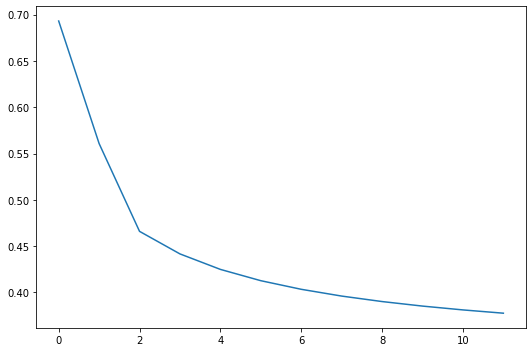

In [ ]:
plt.plot(gd_loss)
plt.show()

In [ ]:
#stochastic gradient descent
iter = 10*num_sam
reg = 3E-5
step_1 = 0.03
m = 30
sgd_loss = []

W_in_sgd = np.zeros((num_fe, num_cl))
W_sgd = SGD(X, Y_hot, W_in_sgd, reg, iter, step_1, sgd_loss)

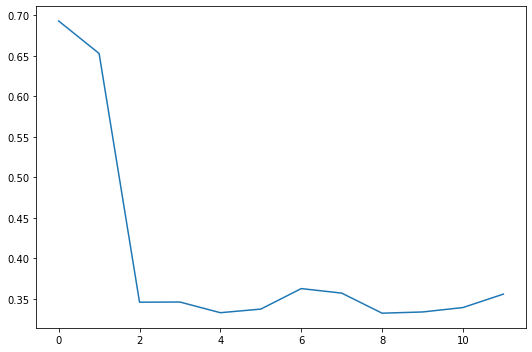

In [ ]:
plt.plot(sgd_loss)
plt.show()

In [ ]:
#stochastic average gradient
iter = 10*num_sam
step_1 = 1/(16*L)
reg = 3E-5
m = 30
sag_loss = []

W_in_sag = np.zeros((num_fe, num_cl))
W_sag = SAG(X, Y_hot, W_in_sag, reg, iter, step_1, sag_loss)

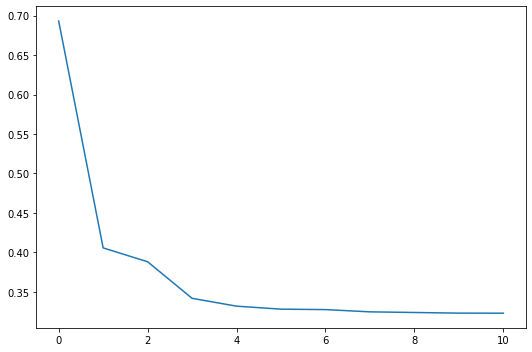

In [ ]:
plt.plot(sag_loss)
plt.show()

In [ ]:
#stochastic variance reduced gradient
iter = 5
step_1 = 0.1/L
reg = 3E-5
m = num_sam
svrg_loss = []

W_in_svrg = np.zeros((num_fe, num_cl))
W_svrg = SVRG(X, Y_hot, W_in_svrg, reg, iter, step_1, svrg_loss, m)

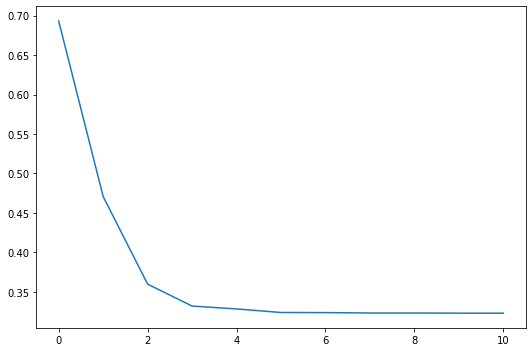

In [ ]:
plt.plot(svrg_loss)
plt.show()

In [ ]:
k = L/reg
j = 5
eps = 1e-3
m = basic_plot(eps,j,k)
plt.clf()
m

1993842.9714363026

<Figure size 540x360 with 0 Axes>

In [ ]:
#semi stochastic gradient descent
iter = 5
step_1 = 0.01
reg = 3E-5
m = num_sam
nu = reg
s2gd_loss = []

W_in_s2gd = np.zeros((num_fe, num_cl))
W_s2gd = S2GD(X, Y_hot, W_in_s2gd, reg, iter, step_1, s2gd_loss, m, nu)

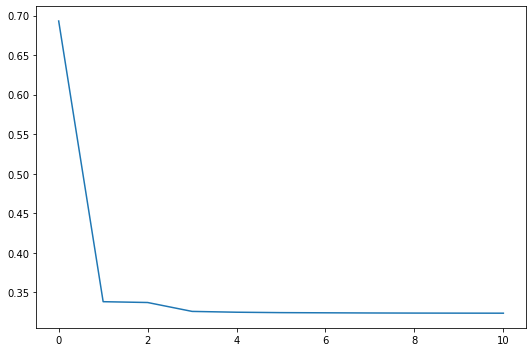

In [ ]:
plt.plot(s2gd_loss)
plt.show()

In [ ]:
#semi stochastic gradient descent plus
iter = 5
reg = 3E-5
step_sgd = 0.1
step_s2gd = 0.05
alpha = 0.8
t = (int)(alpha*num_sam) #stochastic fixed steps in s2gd
s2gd_plus_loss = []
W_in_s2gd_plus = np.zeros((num_fe, num_cl))
W_s2gd_plus = S2GD_plus(X, Y_hot, W_in_s2gd_plus, reg, iter, step_sgd, step_s2gd, t, s2gd_plus_loss)

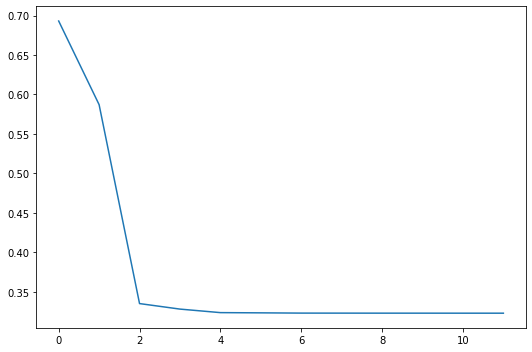

In [ ]:
plt.plot(s2gd_plus_loss)
plt.show()

In [ ]:
#stochastic average gradient plus
iter = 10*num_sam
step_1 = 0.08
reg = 3E-5
sag_plus_loss = []

W_in_sag_plus = np.zeros((num_fe, num_cl))
W_sag_plus = SAG_plus(X, Y_hot, W_in_sag_plus, reg, iter, step_1, sag_plus_loss)

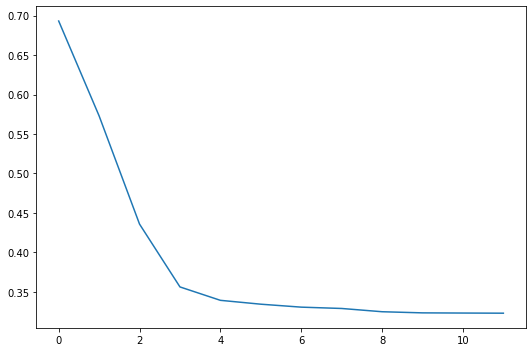

In [ ]:
plt.plot(sag_plus_loss)
plt.show()

In [ ]:
#semi stochastic gradient descent gaussian
iter = 6
step_1 = 0.03
reg = 0.01
m = num_sam
s2gd_p_loss = []
W_in_s2gd_p = np.zeros((num_fe, num_cl))
W_s2gd_p = S2GD_P(X, Y_hot, W_in_s2gd_p, reg, iter, step_1, s2gd_p_loss, m, (int)(m/2), (int)(m/4))

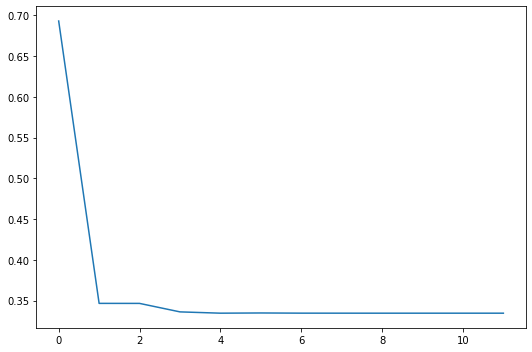

In [ ]:
plt.plot(s2gd_p_loss)
plt.show()

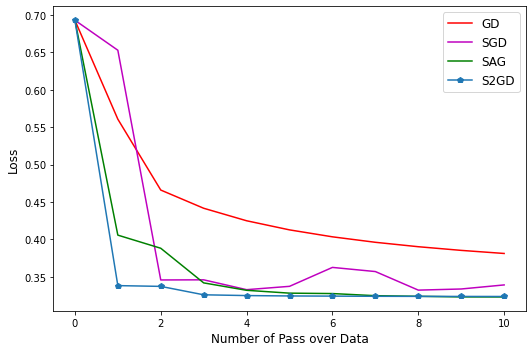

In [ ]:
x1 = np.linspace(0,10,num = 11, endpoint = True)
x2 = np.linspace(0,9,num = 10, endpoint = True)
x3 = np.linspace(0,11,num = 12, endpoint = True)
plt.plot(gd_loss[0:11],'-r',label = "GD")
plt.plot(sgd_loss[0:11],'-m',label = "SGD")
plt.plot(sag_loss, '-g', label = "SAG")
plt.plot(s2gd_loss, '-p', label = "S2GD")
plt.legend(loc = "upper right", prop={'size': 12})
plt.ylabel("Loss", fontsize = 12)
plt.xlabel("Number of Pass over Data", fontsize = 12)
plt.show()

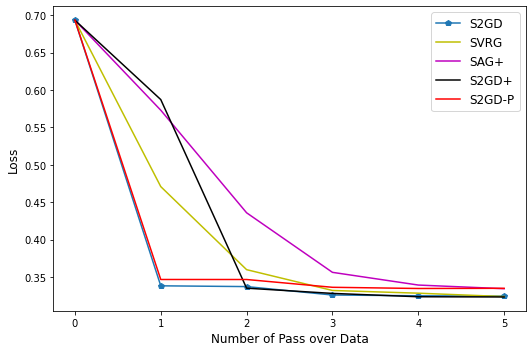

In [ ]:
x1 = np.linspace(0,10,num = 11, endpoint = True)
x2 = np.linspace(0,9,num = 10, endpoint = True)
x3 = np.linspace(0,11,num = 12, endpoint = True)
plt.plot(s2gd_loss[0:6], '-p', label = "S2GD")
plt.plot(svrg_loss[0:6], '-y', label = "SVRG")
plt.plot(sag_plus_loss[0:6], '-m', label = "SAG+")
plt.plot(s2gd_plus_loss[0:6], '-k', label = "S2GD+")
plt.plot(s2gd_p_loss[0:6], '-r', label = "S2GD-P")
plt.legend(loc = "upper right", prop={'size': 12})
plt.ylabel("Loss", fontsize = 12)
plt.xlabel("Number of Pass over Data", fontsize = 12)
plt.show()

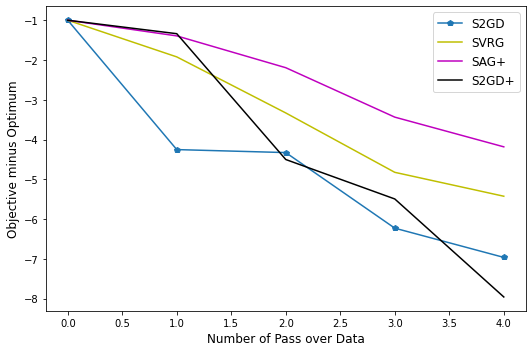

In [ ]:
x1 = np.linspace(0,10,num = 11, endpoint = True)
x2 = np.linspace(0,9,num = 10, endpoint = True)
x3 = np.linspace(0,11,num = 12, endpoint = True)
plt.plot(np.log(abs(s2gd_loss[0:5] - fx_star)), '-p', label = "S2GD")
plt.plot(np.log(abs(svrg_loss[0:5] - fx_star)), '-y', label = "SVRG")
plt.plot(np.log(abs(sag_plus_loss[0:5] - fx_star)), '-m', label = "SAG+")
plt.plot(np.log(abs(s2gd_plus_loss[0:5] - fx_star)), '-k', label = "S2GD+")
plt.legend(loc = "upper right", prop={'size': 12})
plt.ylabel("Objective minus Optimum", fontsize = 12)
plt.xlabel("Number of Pass over Data", fontsize = 12)
plt.show()

### Multiclass Classification Dataset

In [ ]:
Y, x = svm_read_problem('/content/drive/MyDrive/letter.scale', return_scipy = True)

In [ ]:
X = x.toarray()
print(X.shape)
print(Y.shape)
Y = Y.astype(int)

(15000, 16)
(15000,)


In [ ]:
num_cl = (np.max(Y) + 1) #total number of classes
num_fe = np.shape(X)[1] #number of features
num_sam = np.shape(X)[0] #number of samples

In [ ]:
Y_hot = np.zeros((num_sam, num_cl))
for i in range(num_sam):
  Y_hot[i][Y[i]-1] = 1

In [ ]:
L = Lipschitz(X,1/(num_sam))
L

1.709082510444128

In [ ]:
#gradient descent
iter = 25
step_1 = 30/L
reg = 1/num_sam
m = 30
gd_loss = []

W_in_gd = np.zeros((num_fe, num_cl))
W_gd = GD(X, Y_hot, W_in_gd, reg, iter, step_1, gd_loss)

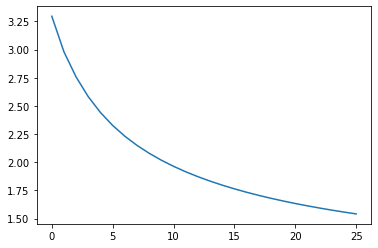

In [ ]:
plt.plot(gd_loss)
plt.show()

In [ ]:
#gradient descent
iter = 500
step_1 = 10/L
reg = 1/num_sam
m = 30
gd_loss2 = []

W_in_gd2 = np.zeros((num_fe, num_cl))
W_gd2 = GD2(X, Y_hot, W_in_gd, reg, iter, step_1, gd_loss2)

In [ ]:
fx_star = objective(X, Y_hot, W_gd2, reg)
type(fx_star)

numpy.float64

In [ ]:
#stochastic gradient descent
iter = 25*num_sam
reg = 1/(num_sam)
step_1 = 0.1
m = 30
sgd_loss = []

W_in_sgd = np.zeros((num_fe, num_cl))
W_sgd = SGD(X, Y_hot, W_in_sgd, reg, iter, step_1, sgd_loss)

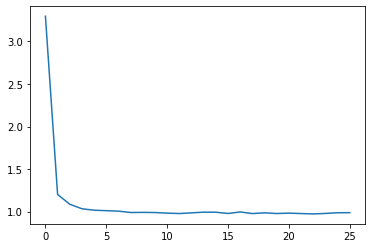

In [ ]:
plt.plot(sgd_loss)
plt.show()

In [ ]:
#stochastic average gradient
iter = 25*num_sam
step_1 = 4/(16*L)
reg = 1/(num_sam)
m = 30
sag_loss = []

W_in_sag = np.zeros((num_fe, num_cl))
W_sag = SAG(X, Y_hot, W_in_sag, reg, iter, step_1, sag_loss)

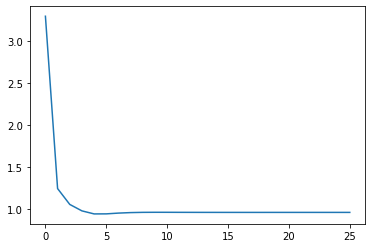

In [ ]:
plt.plot(sag_loss)
plt.show()

In [ ]:
#semi stochastic gradient descent
iter = 13
step_1 = 0.12
reg = 1/(num_sam)
m = 10*num_sam
nu = reg
s2gd_loss = []

W_in_s2gd = np.zeros((num_fe, num_cl))
W_s2gd = S2GD(X, Y_hot, W_in_s2gd, reg, iter, step_1, s2gd_loss, m, nu)

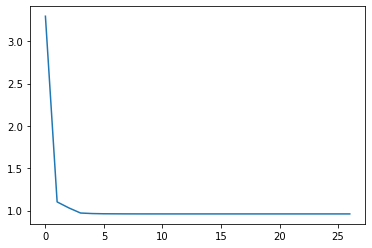

In [ ]:
plt.plot(s2gd_loss)
plt.show()

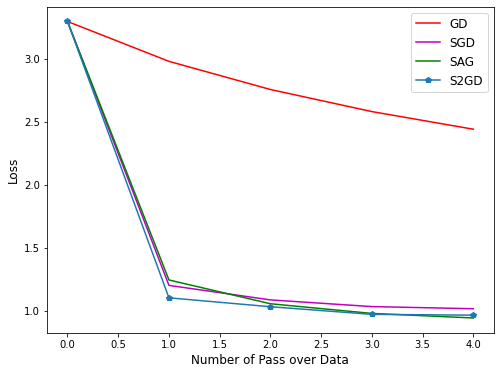

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(gd_loss[0:5],'-r',label = "GD")
plt.plot(sgd_loss[0:5],'-m',label = "SGD")
plt.plot(sag_loss[0:5], '-g', label = "SAG")
plt.plot(s2gd_loss[0:5], '-p', label = "S2GD")
plt.legend(loc = "upper right", prop={'size': 12})
plt.ylabel("Loss", fontsize = 12)
plt.xlabel("Number of Pass over Data", fontsize = 12)
plt.show()

In [ ]:
#stochastic variance reduced gradient
iter = 20
step_1 = 0.12
reg = 1/num_sam
m = num_sam
svrg_loss = []

W_in_svrg = np.zeros((num_fe, num_cl))
W_svrg = SVRG(X, Y_hot, W_in_svrg, reg, iter, step_1, svrg_loss, m)

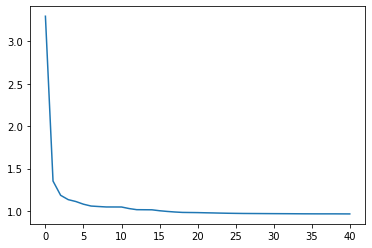

In [ ]:
plt.plot(svrg_loss)
plt.show()

In [ ]:
#semi stochastic gradient descent plus
iter = 13
reg = 1/num_sam
step_sgd = 0.6
step_s2gd = 0.3
alpha = 2
t = (int)(alpha*num_sam) #stochastic fixed steps in s2gd
s2gd_plus_loss = []
W_in_s2gd_plus = np.zeros((num_fe, num_cl))
W_s2gd_plus = S2GD_plus(X, Y_hot, W_in_s2gd_plus, reg, iter, step_sgd, step_s2gd, t, s2gd_plus_loss)

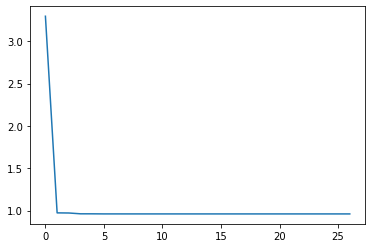

In [ ]:
plt.plot(s2gd_plus_loss)
plt.show()

In [ ]:
#stochastic average gradient plus
iter = 20*num_sam
step_1 = 0.12
reg = 1/num_sam
sag_plus_loss = []

W_in_sag_plus = np.zeros((num_fe, num_cl))
W_sag_plus = SAG_plus(X, Y_hot, W_in_sag_plus, reg, iter, step_1, sag_plus_loss)

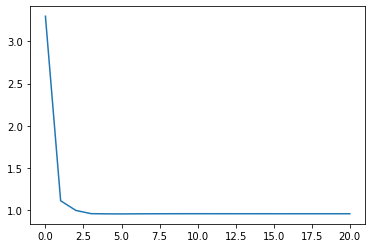

In [ ]:
plt.plot(sag_plus_loss)
plt.show()

In [ ]:
#semi stochastic gradient descent gaussian
iter = 13
step_1 = 0.12
reg = 1/num_sam
m = 4*num_sam
s2gd_p_loss = []
W_in_s2gd_p = np.zeros((num_fe, num_cl))
W_s2gd_p = S2GD_P(X, Y_hot, W_in_s2gd_p, reg, iter, step_1, s2gd_p_loss, m, (int)(m/2), (int)(m/4))

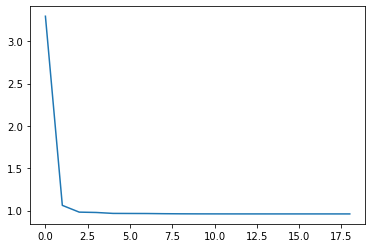

In [ ]:
plt.plot(s2gd_p_loss)
plt.show()

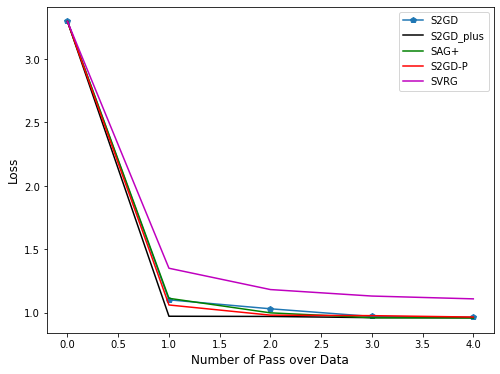

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(s2gd_loss[0:5],'-p',label = "S2GD")
plt.plot(s2gd_plus_loss[0:5],'-k',label = "S2GD_plus")
plt.plot(sag_plus_loss[0:5], '-g', label = "SAG+")
plt.plot(s2gd_p_loss[0:5], '-r', label = "S2GD-P")
plt.plot(svrg_loss[0:5], '-m', label = "SVRG")
plt.legend(loc = "upper right", prop={'size': 10})
plt.ylabel("Loss", fontsize = 12)
plt.xlabel("Number of Pass over Data", fontsize = 12)
plt.show()

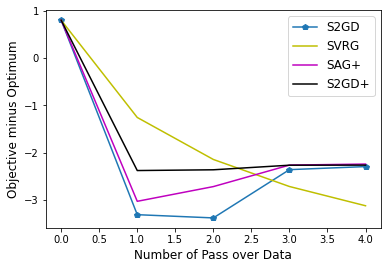

In [ ]:
plt.plot(np.log(abs(s2gd_loss[0:5] - fx_star)), '-p', label = "S2GD")
plt.plot(np.log(abs(svrg_loss[0:5] - fx_star)), '-y', label = "SVRG")
plt.plot(np.log(abs(sag_plus_loss[0:5] - fx_star)), '-m', label = "SAG+")
plt.plot(np.log(abs(s2gd_plus_loss[0:5] - fx_star)), '-k', label = "S2GD+")
plt.legend(loc = "upper right", prop={'size': 12})
plt.ylabel("Objective minus Optimum", fontsize = 12)
plt.xlabel("Number of Pass over Data", fontsize = 12)
plt.show()

### Regression 

In [77]:
def objective(X, Y, W, reg):
  Z = Y - X @ W
  A = (Z.T @ Z)/(2*X.shape[0])
  return A[0]

In [28]:
def grad(X, Y, W, reg):
  Z = X @ W - Y
  G = (X.T @ Z)/X.shape[0] + reg*W
  return G

In [96]:
def stoc_grad(X, Y, W, reg):
  n = np.shape(X)[0]
  i = random.sample(range(0, n - 1), 1)[0] # Uniform Random sampling for SGD
  X = X[i, :].reshape((1, num_fe))
  Y = Y[i]
  return grad(X, Y, W, reg)

In [87]:
def stoc_grad2(X, Y, W, reg, i):
  X = X[i, :].reshape((1, num_fe))
  Y = Y[i]
  return grad(X, Y, W, reg)

In [14]:
def Lipschitz_reg(X, reg):
  val = np.sqrt(np.linalg.eigvals(X.T @ X)[0]) + reg
  return val

In [166]:
Y, x = svm_read_problem('/content/drive/MyDrive/cpusmall.txt', return_scipy = True)
X = x.toarray()

In [167]:
num_sam = X.shape[0]
num_fe = X.shape[1]
reg = 1 / num_sam
L = Lipschitz_reg(X, reg)
L

265.4801434523013

In [168]:
Y = Y.reshape((num_sam, 1))
print(X.shape)
print(Y.shape)

(8192, 12)
(8192, 1)


In [190]:
#semi stochastic gradient descent
iter = 10
step_1 = 0.1
m = num_sam
nu = reg
s2gd_loss = []

W_in_s2gd = np.zeros((num_fe, 1))
W_s2gd = S2GD(X, Y, W_in_s2gd, reg, iter, step_1, s2gd_loss, m, nu)

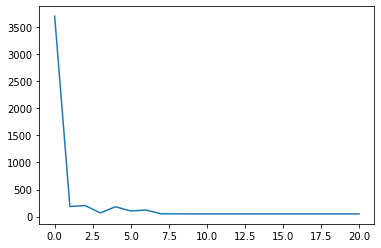

In [191]:
plt.plot(s2gd_loss)
plt.show()

In [188]:
#semi stochastic gradient descent plus
iter = 10
step_sgd = 0.2
step_s2gd = 0.1
alpha = 0.8
t = (int)(alpha*num_sam) #stochastic fixed steps in s2gd
s2gd_plus_loss = []
W_in_s2gd_plus = np.zeros((num_fe, 1))
W_s2gd_plus = S2GD_plus(X, Y, W_in_s2gd_plus, reg, iter, step_sgd, step_s2gd, t, s2gd_plus_loss)

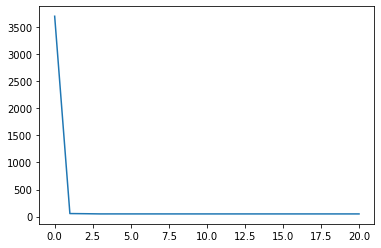

In [189]:
plt.plot(s2gd_plus_loss)

### Loopless S2GD

In [175]:
def Loopless_S2GD(X, Y, W, reg, iter, step, loss, prob):
  old_grad = grad(X, Y, W, reg)
  prev = W
  arr = []
  arr.append(prob)
  arr.append(1-prob)
  loss.append(objective(X, Y, W, reg))
  for i in range(iter):
    j = random.sample(range(0, num_sam - 1), 1)[0]
    new_grad = stoc_grad2(X, Y, W, reg, j) - stoc_grad2(X, Y, prev, reg, j) + old_grad
    W_new = W - step*new_grad
    flag = np.random.choice(np.arange(1,3),p = arr) #random sampling from probability p and 1-p
    if flag == 1:
      prev = W
      old_grad = grad(X, Y, W, reg)
    W = W_new
    if ((i+1) % num_sam == 0):
      loss.append(objective(X, Y, W, reg))
  return W

In [199]:
#Loopless Semi Stochastic Gradient Descent 
iter = 10*num_sam
step_1 = 0.07
m = num_sam
nu = reg
s2gd_loop_loss = []
prob = 1/num_sam

W_in_s2gd_loop = np.zeros((num_fe, 1))
W_s2gd_loop = Loopless_S2GD(X, Y, W_in_s2gd_loop, reg, iter, step_1, s2gd_loop_loss, prob)

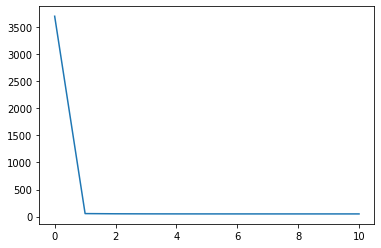

In [177]:
plt.plot(s2gd_loop_loss)

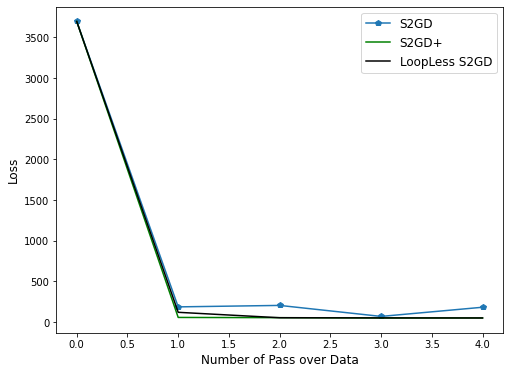

In [200]:
plt.figure(figsize=(8, 6))
plt.plot(s2gd_loss[0:5], '-p', label = "S2GD")
plt.plot(s2gd_plus_loss[0:5],'-g', label = "S2GD+")
plt.plot(s2gd_loop_loss[0:5], '-k', label = "LoopLess S2GD")
plt.legend(loc = "upper right", prop={'size': 12})
plt.ylabel("Loss", fontsize = 12)
plt.xlabel("Number of Pass over Data", fontsize = 12)
plt.show()